In [1]:
import turicreate as tc
import numpy
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# turicreate lacks KFOLDs
# source: https://github.com/Kagandi/turicreate-cross-validation/blob/master/turicreate_cross_validation/cross_validation.py

# import turicreate_cross_validation as tcv

# from turicreate_cross_validation import shuffle_sframe, StratifiedKFold, cross_val_score

# -*- coding: utf-8 -*-
"""
This module API is mostly compatible with the old graphlab-create cross_validation module.
https://turi.com/products/create/docs/graphlab.toolkits.cross_validation.html
"""
import numpy as np
import turicreate as tc
from collections import defaultdict
from turicreate.toolkits._internal_utils import _raise_error_if_column_exists
from turicreate.toolkits._main import ToolkitError


def _get_classification_metrics(model, targets, predictions):
    """

    Parameters
    ----------
    model: Classifier
        Turi create trained classifier.
    targets: SArray
        Array containing the expected labels.
    predictions: SArray
        Array containing the predicted labels.

    Returns
    -------
    dict
        An average metrics of the n folds.

    """
    precision = tc.evaluation.precision(targets, predictions)
    accuracy = tc.evaluation.accuracy(targets, predictions)
    recall = tc.evaluation.recall(targets, predictions)
    auc = tc.evaluation.auc(targets, predictions)
    return {"recall": recall,
            "precision": precision,
            "accuracy": accuracy,
            "auc": auc
            }


def _kfold_sections(data, n_folds):
    """
    Calculate the indexes of the splits that should
    be used to split the data into n_folds.

    Parameters
    ----------
    data: SFrame
        A Non empty SFrame.
    n_folds: int
        The number of folds to create. Must be at least 2.


    Yields
    -------
    (int, int)
        Yields the first and last index of the fold.

    Notes
    -----
        Based on scikit implementation.
    """
    Neach_section, extras = divmod(len(data), n_folds)
    section_sizes = ([0] +
                     extras * [Neach_section + 1] +
                     (n_folds - extras) * [Neach_section])
    div_points = np.array(section_sizes).cumsum()
    for i in range(n_folds):
        st = div_points[i]
        end = div_points[i + 1]
        yield st, end


def shuffle_sframe(sf, random_seed=None, temp_shuffle_col="shuffle_col"):
    """
    Create a copy of the SFrame where the rows have been shuffled randomly.

    Parameters
    ----------
    sf: SFrame
        A Non empty SFrame.
    random_seed: int, optional
        Random seed to use for the randomization. If provided, each call
        to this method will produce an identical result.
    temp_shuffle_col: str, optional
        Change only if you use the same column name.

    Returns
    -------
    SFrame
        A randomly shuffled SFrame.

    Examples
    --------
        >>> url = 'https://static.turi.com/datasets/xgboost/mushroom.csv'
        >>> sf = tc.SFrame.read_csv(url)
        >>> shuffle_sframe(sf)
    """

    if temp_shuffle_col in sf.column_names():
        raise ToolkitError('The SFrame already contains column named {0}. '
                           'Please enter set another value to temp_shuffle_col'.format(temp_shuffle_col))
    shuffled_sframe = sf.copy()
    shuffled_sframe[temp_shuffle_col] = tc.SArray.random_integers(sf.num_rows(), random_seed)
    return shuffled_sframe.sort(temp_shuffle_col).remove_column(temp_shuffle_col)


def KFold(data, n_folds=10):
    """
    Create a K-Fold split of a data set as an iterable/indexable object of K pairs,
    where each pair is a partition of the dataset.  This can be useful for cross
    validation, where each fold is used as a held out dataset while training
    on the remaining data.

    Parameters
    ----------
    data: SFrame
        A Non empty SFrame.
    n_folds: int
        The number of folds to create. Must be at least 2.

    Notes
    -----
    This does not shuffle the data. Shuffling your data is a useful preprocessing step when doing cross validation.

    Yields
    -------
    (SArray, SArray)
        Yields train, test of each fold

    Examples
    --------
        >>> url = 'https://static.turi.com/datasets/xgboost/mushroom.csv'
        >>> sf = tc.SFrame.read_csv(url)
        >>> folds = KFold(sf)
    """
    if data.num_rows() < n_folds:
        raise ValueError
    for st, end in _kfold_sections(data, n_folds):
        idx = np.zeros(len(data))
        idx[st:end] = 1
        yield data[tc.SArray(1 - idx)], data[tc.SArray(idx)]


def StratifiedKFold(data, label='label', n_folds=10):
    """
    Create a Stratified K-Fold split of a data set as an iteratable/indexable object
    of K pairs, where each pair is a partition of the data set. This can be useful
    for cross validation, where each fold is used as a heldout dataset while
    training on the remaining data. Unlike the regular KFold the folds are
    made by preserving the percentage of samples for each class.
    The StratifiedKFold is more suitable for smaller datasets
    or for datasets where there a is a minority class.

    Parameters
    ----------
    data: SFrame
        A Non empty SFrame.
    label: str
        The target/class column name in the SFrame.
    n_folds: int
        The number of folds to create. Must be at least 2.

    Notes
    -----
    This does not shuffle the data. Shuffling your data is a useful preprocessing step when doing cross validation.

    Yields
    -------
    (SArray, SArray)
        Yields train, test of each fold

    Examples
    --------
        >>> url = 'https://static.turi.com/datasets/xgboost/mushroom.csv'
        >>> sf = tc.SFrame.read_csv(url)
        >>> folds = StratifiedKFold(sf)
    """
    _raise_error_if_column_exists(data, label, 'data', label)

    labels = data[label].unique()
    labeled_data = [data[data[label] == l] for l in labels]
    fold = [KFold(item, n_folds) for item in labeled_data]
    for _ in range(n_folds):
        train, test = tc.SFrame(), tc.SFrame()
        for f in fold:
            x_train, x_test = f.next()
            train = train.append(x_train)
            test = test.append(x_test)
        yield train, test


def cross_val_score(datasets, model_factory, model_parameters=None, evaluator=_get_classification_metrics):
    """
    Evaluate model performance via cross validation for a given set of parameters.

    Parameters
    ----------
    datasets: iterable of tuples
        The data used to train the model on a format of iterable of tuples.
        The tuples should be in a format of (train, test).
    model_factory: function
        This is the function used to create the model.
        For example, to perform model_parameter_search using the
        GraphLab Create model graphlab.linear_regression.LinearRegression,
        the model_factory is graphlab.linear_regression.create().
    model_parameters: dict
        The params argument takes a dictionary containing parameters that will be passed to the provided model factory.
    evaluator: function (model, training_set, validation_set) -> dict, optional
        The evaluation function takes as input the model, training and validation SFrames,
        and returns a dictionary of evaluation metrics where each value is a simple type, e.g. float, str, or int.

    Returns
    -------
    dict
        The calculate metrics for the cross validation.

    Examples
    --------
        >>> url = 'https://static.turi.com/datasets/xgboost/mushroom.csv'
        >>> sf = tc.SFrame.read_csv(url)
        >>> folds = StratifiedKFold(sf)
        >>> params = {'target': 'label'}
        >>> cross_val_score(folds, tc.random_forest_classifier.create, params)
    """
    if not model_parameters:
        model_parameters = {'target': 'label'}
    label = model_parameters['target']

    cross_val_metrics = defaultdict(list)
    for train, test in datasets:

        _raise_error_if_column_exists(train, label, 'train', label)
        _raise_error_if_column_exists(test, label, 'test', label)

        model = model_factory(train, **model_parameters)
        prediction = model.predict(test)
        metrics = evaluator(model, test[label], prediction)
        for k, v in metrics.iteritems():
            cross_val_metrics[k].append(v)
    return {k: np.mean(v) for k, v in cross_val_metrics.iteritems()}

In [3]:
def polynomial_sframe(feature, degree):
    # assume that degree >= 1
    # initialize the SFrame:
    poly_sframe = tc.SFrame()
    # and set poly_sframe['power_1'] equal to the passed feature
    poly_sframe['power_1'] = feature
    # first check if degree > 1
    if degree > 1:
        # then loop over the remaining degrees:
        # range usually starts at 0 and stops at the endpoint-1. We want it to start at 2 and stop at degree
        for power in range(2, degree+1): 
            # first we'll give the column a name:
            name = 'power_' + str(power)
            # then assign poly_sframe[name] to the appropriate power of feature
            poly_sframe[name] = poly_sframe['power_1'].apply(lambda x: x**power)
    return poly_sframe

In [4]:
def print_coefficients(model):    
    # Get the degree of the polynomial
    deg = len(model.coefficients['value'])-1

    # Get learned parameters as a list
    w = list(model.coefficients['value'])

    # Numpy has a nifty function to print out polynomials in a pretty way
    # (We'll use it, but it needs the parameters in the reverse order)
    print('Learned polynomial for degree ' + str(deg) + ':')
    w.reverse()
    print(numpy.poly1d(w))

In [5]:
sales = tc.SFrame('kc_house_data.gl/')

In [6]:
sales = sales.sort(['sqft_living','price'])

Let us revisit the 15th-order polynomial model using the 'sqft_living' input. Generate polynomial features up to degree 15 using polynomial_sframe() and fit a model with these features. When fitting the model, use an L2 penalty of 1e-5:

In [7]:
# set regression lambda
l2_small_penalty = 1e-5

In [8]:
def polynomial_regression_plot(degree, df):
    fig, axes = plt.subplots(3, 5, sharex=True, sharey=True, figsize=(20,15))
    
    for i, ax in enumerate(axes.flatten(), 1):
        poly_data = polynomial_sframe(df['sqft_living'], i)
        features = poly_data.column_names() # get the name of the features
        poly_data['price'] = df['price'] # add price to the data since it's the target
        model = tc.linear_regression.create(poly_data, 
                                            target = 'price', 
                                            features = features, 
                                            validation_set = None, 
                                            verbose=False,
                                           l2_penalty=l2_small_penalty)
        
        if i == degree:
            print_coefficients(model)
            
        ax.plot(poly_data['power_1'], 
                     poly_data['price'],'.', 
                     poly_data['power_1'], 
                     model.predict(poly_data),'-')
    
    plt.show()

Learned polynomial for degree 15:
           15             14             13             12
1.137e-53 x  - 3.796e-49 x  - 3.658e-46 x  + 6.905e-41 x 
              11            10             9             8
 + 7.228e-37 x  - 7.29e-33 x  - 2.333e-28 x - 4.788e-25 x
              7             6             5             4             3
 + 4.512e-20 x + 1.711e-16 x - 7.772e-12 x + 5.189e-08 x - 0.0001291 x
           2
 + 0.1346 x + 103.1 x + 1.679e+05


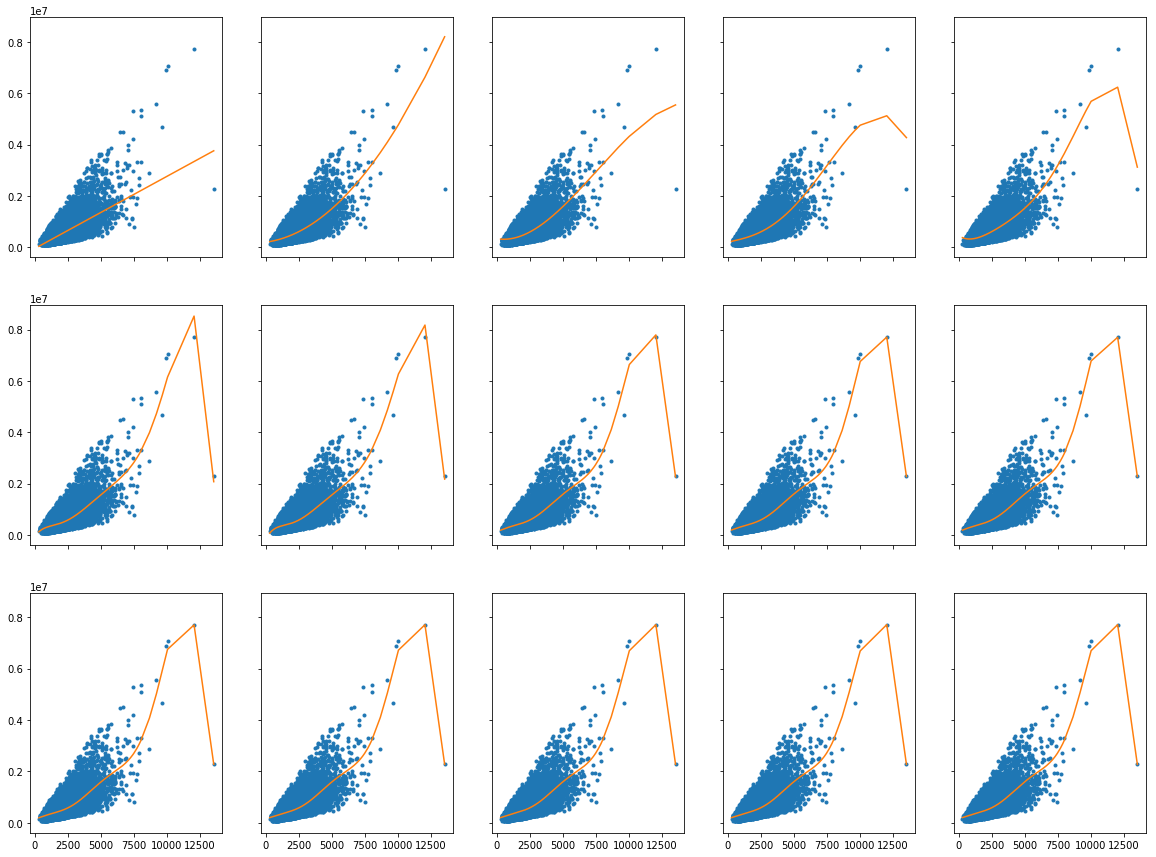

In [9]:
polynomial_regression_plot(15, sales) # question 1

In [10]:
(semi_split1, semi_split2) = sales.random_split(.5,seed=0)
(set_1, set_2) = semi_split1.random_split(0.5, seed=0)
(set_3, set_4) = semi_split2.random_split(0.5, seed=0)

Learned polynomial for degree 15:
            15             14           13             12
-2.338e-53 x  + 1.527e-49 x  + 3.8e-45 x  + 2.851e-41 x 
              11             10             9             8
 - 1.627e-37 x  - 6.838e-33 x  - 6.928e-29 x + 1.593e-25 x
              7             6             5             4             3
 + 1.069e-20 x + 5.975e-17 x - 3.798e-13 x - 1.529e-08 x + 0.0001415 x
           2
 - 0.3973 x + 585.9 x + 9306


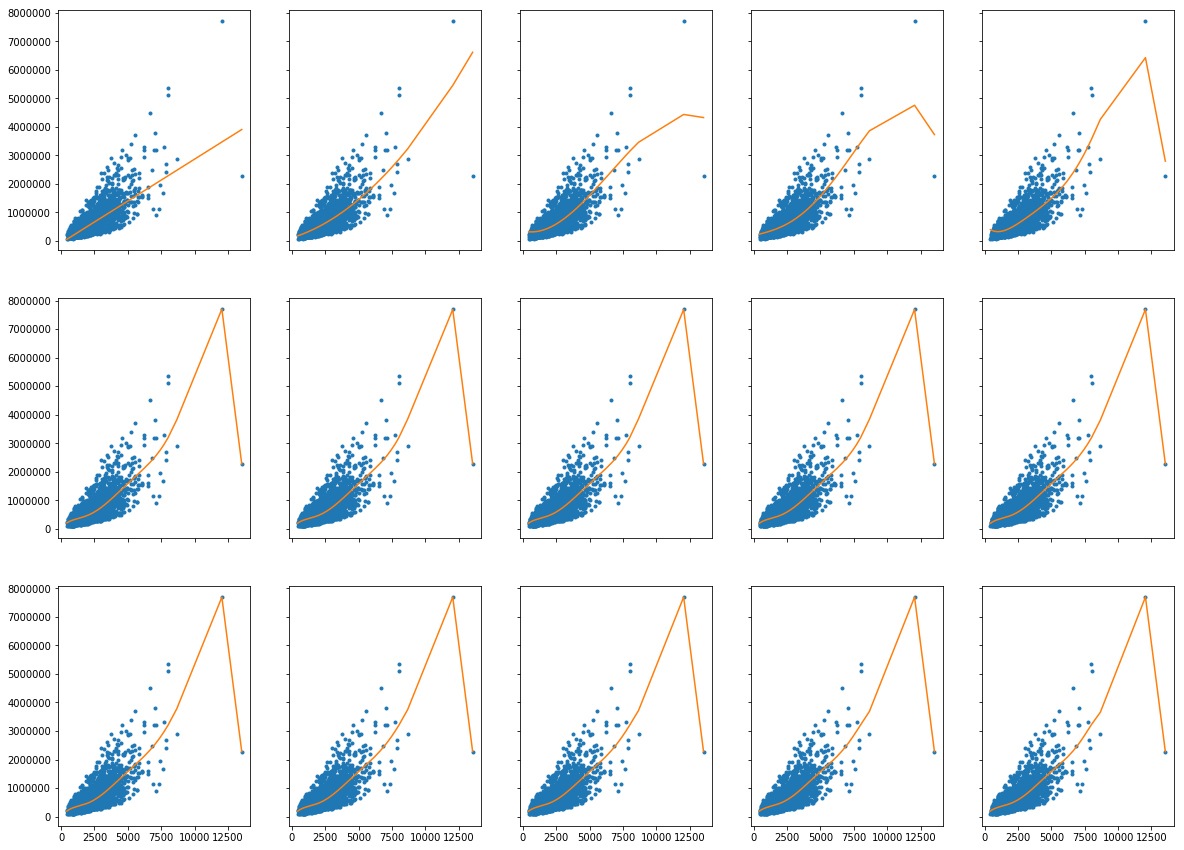

In [11]:
polynomial_regression_plot(15, set_1) # question 2

Learned polynomial for degree 15:
           15             14             13             12
1.301e-50 x  - 1.004e-46 x  - 1.024e-42 x  - 9.413e-40 x 
              11             10             9             8
 + 6.517e-35 x  + 6.218e-31 x  - 2.713e-29 x - 4.597e-23 x
              7             6             5             4             3
 - 2.064e-19 x + 2.512e-15 x + 6.843e-12 x - 1.152e-07 x + 0.0004388 x
           2
 - 0.7678 x + 783.5 x - 2.512e+04


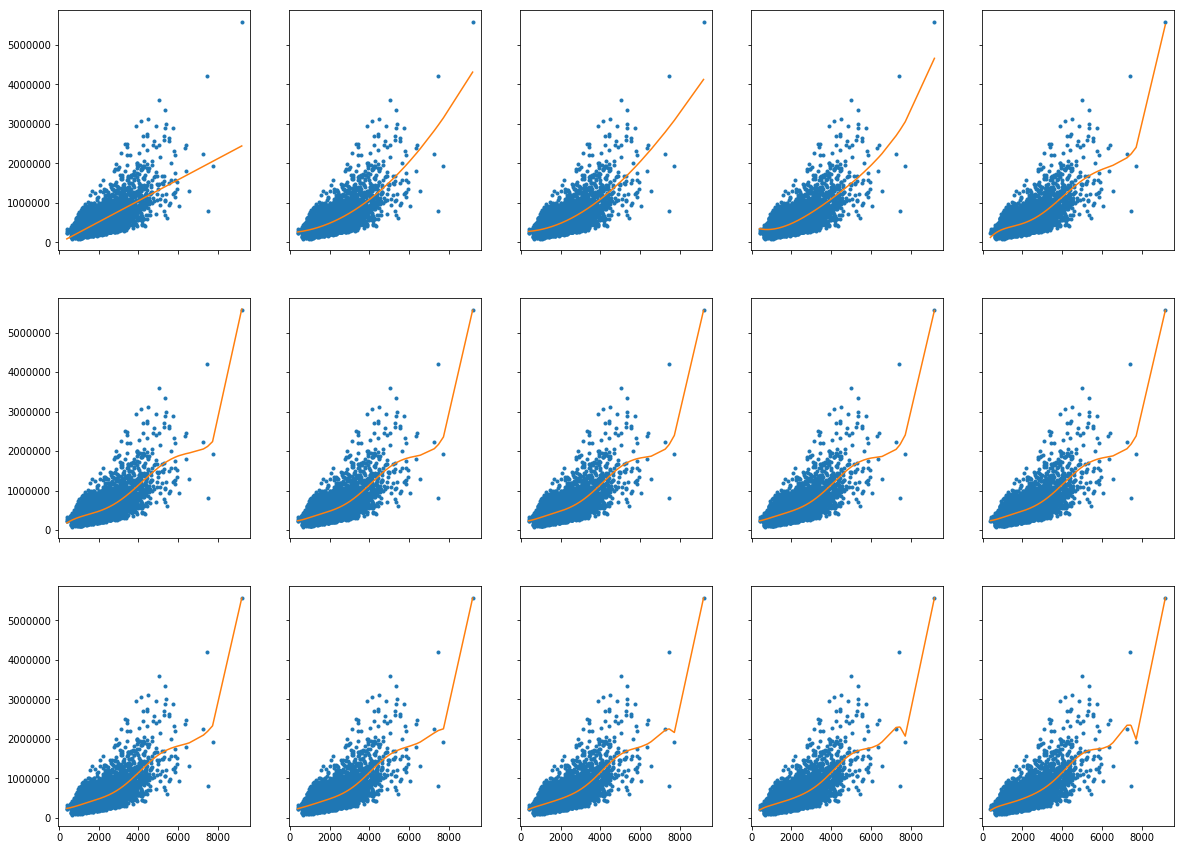

In [12]:
polynomial_regression_plot(15, set_2) # question 2

Learned polynomial for degree 15:
            15             14             13             12
-2.858e-51 x  + 3.556e-47 x  + 2.426e-43 x  - 1.066e-39 x 
              11            10             9             8
 - 2.968e-35 x  - 1.72e-31 x  + 1.243e-27 x + 2.571e-23 x
              7             6             5             4             3
 + 4.088e-20 x - 2.082e-15 x - 2.261e-12 x + 1.154e-07 x - 0.0005283 x
          2
 + 1.029 x - 759.3 x + 4.624e+05


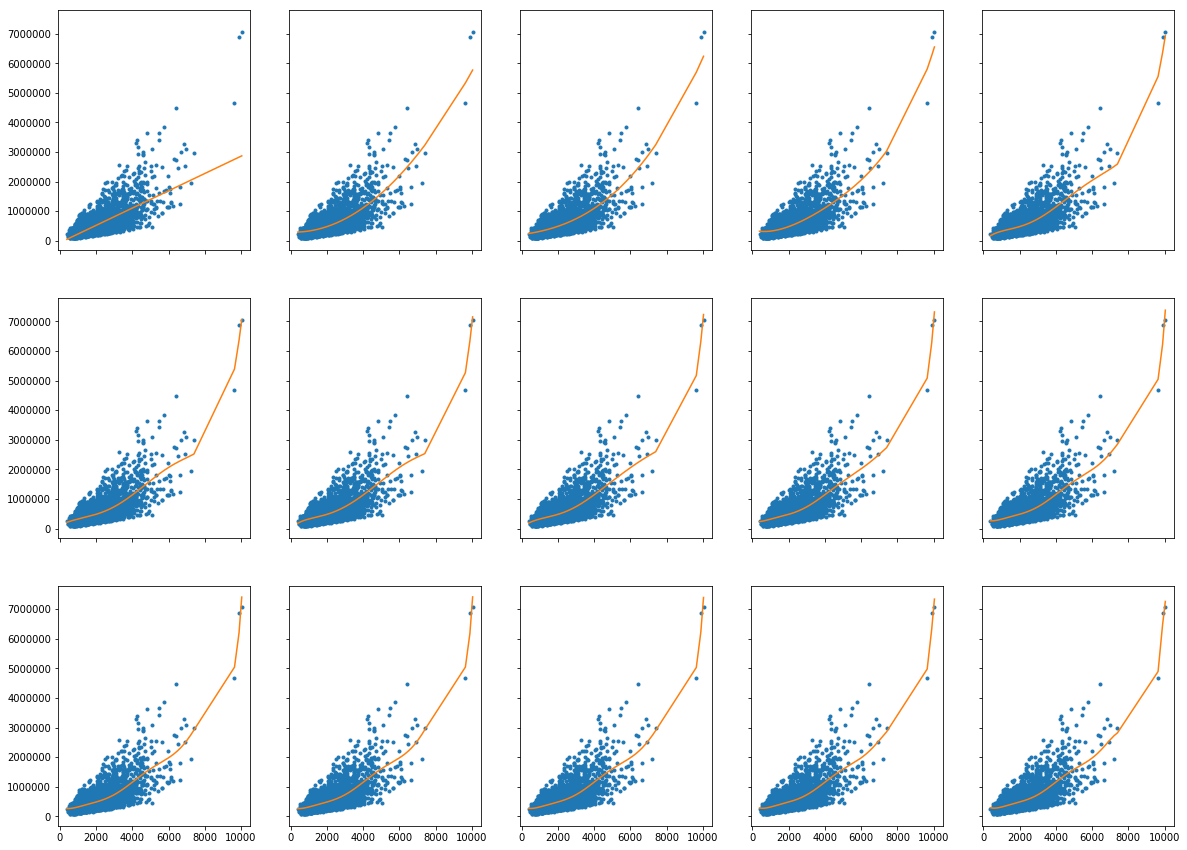

In [13]:
polynomial_regression_plot(15, set_3) # question 2

Learned polynomial for degree 15:
           15             14             13             12
4.395e-50 x  - 6.029e-46 x  - 1.799e-42 x  + 2.334e-38 x 
              11             10             9             8
 + 2.399e-34 x  + 1.602e-31 x  - 1.324e-26 x - 7.999e-23 x
              7             6             5             4             3
 + 4.215e-19 x + 4.818e-15 x - 2.202e-11 x - 6.383e-08 x + 0.0005553 x
          2
 - 1.225 x + 1248 x - 1.702e+05


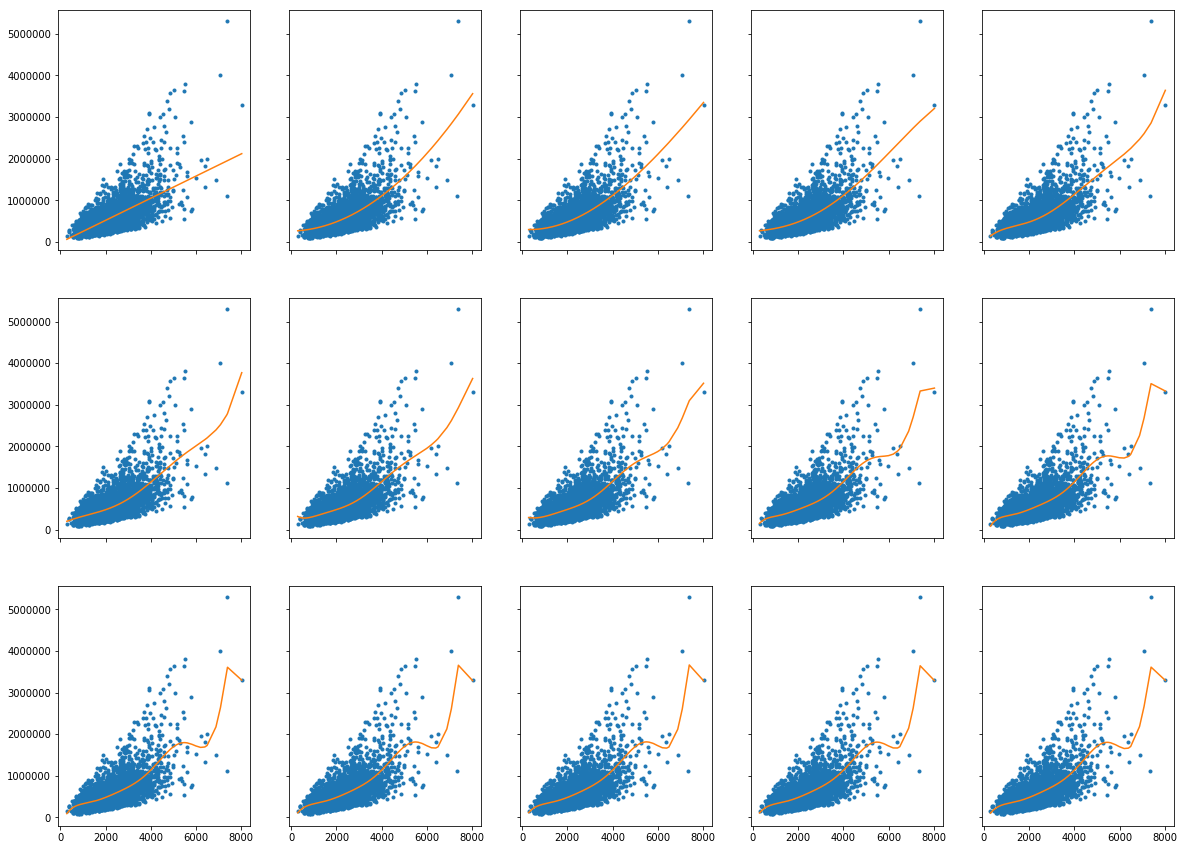

In [14]:
polynomial_regression_plot(15, set_4) # question 2

In [15]:
l2_large_penalty = 1e5

In [16]:
def polynomial_regression_plot(degree, df):
    fig, axes = plt.subplots(3, 5, sharex=True, sharey=True, figsize=(20,15))
    
    for i, ax in enumerate(axes.flatten(), 1):
        poly_data = polynomial_sframe(df['sqft_living'], i)
        features = poly_data.column_names() # get the name of the features
        poly_data['price'] = df['price'] # add price to the data since it's the target
        model = tc.linear_regression.create(poly_data, 
                                            target = 'price', 
                                            features = features, 
                                            validation_set = None, 
                                            verbose=False,
                                           l2_penalty=l2_large_penalty)
        
        if i == degree:
            print_coefficients(model)
            
        ax.plot(poly_data['power_1'], 
                     poly_data['price'],'.', 
                     poly_data['power_1'], 
                     model.predict(poly_data),'-')
    
    plt.show()

Learned polynomial for degree 15:
           15             14             13             12
3.601e-58 x  + 5.845e-54 x  + 9.392e-50 x  + 1.498e-45 x 
              11             10             9             8
 + 2.382e-41 x  + 3.789e-37 x  + 6.066e-33 x + 9.861e-29 x
             7             6             5            4             3
 + 1.65e-24 x + 2.896e-20 x + 5.422e-16 x + 1.06e-11 x + 1.749e-07 x
             2
 + 0.001274 x + 2.587 x + 5.303e+05


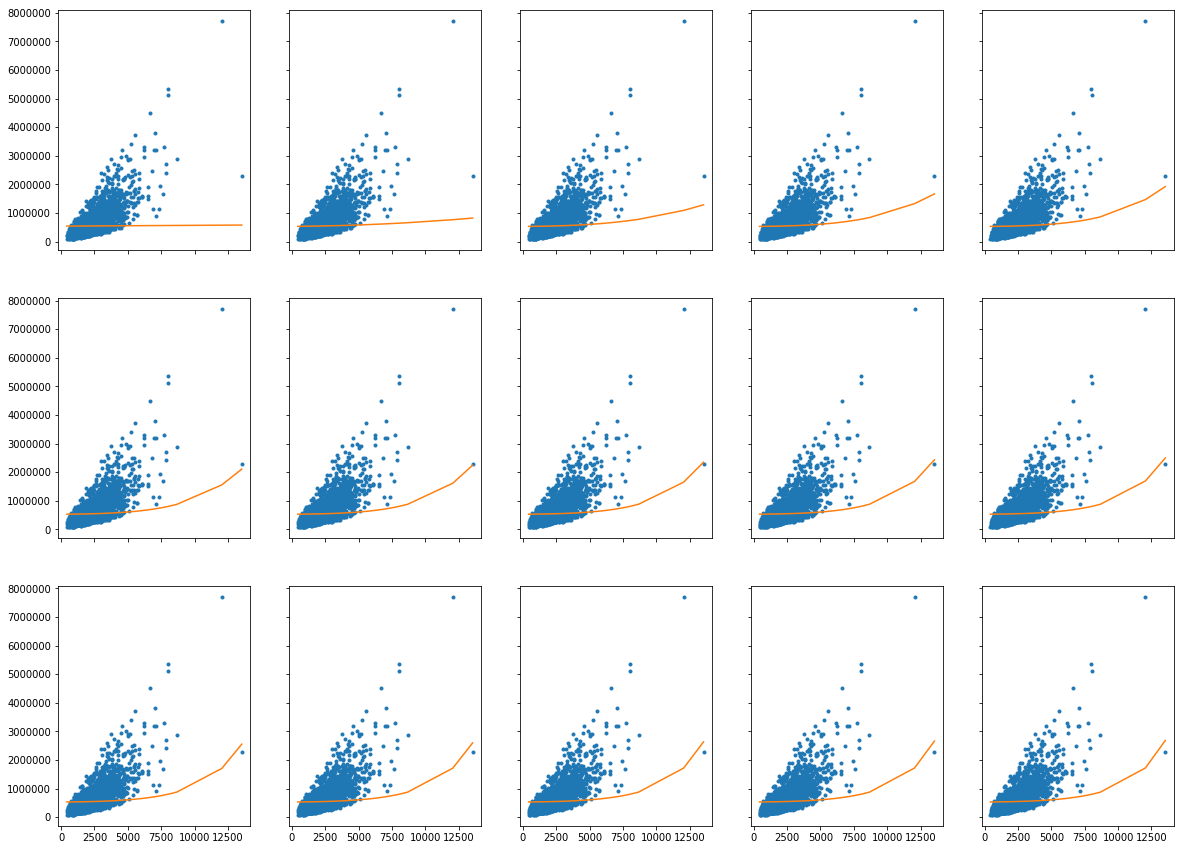

In [17]:
polynomial_regression_plot(15, set_1) # question 3

Learned polynomial for degree 15:
           15             14             13             12
4.715e-55 x  + 4.427e-51 x  + 4.183e-47 x  + 3.985e-43 x 
              11             10             9             8
 + 3.842e-39 x  + 3.767e-35 x  + 3.777e-31 x + 3.901e-27 x
             7             6             5             4             3
 + 4.16e-23 x + 4.531e-19 x + 4.808e-15 x + 4.435e-11 x + 2.931e-07 x
             2
 + 0.001131 x + 2.045 x + 5.192e+05


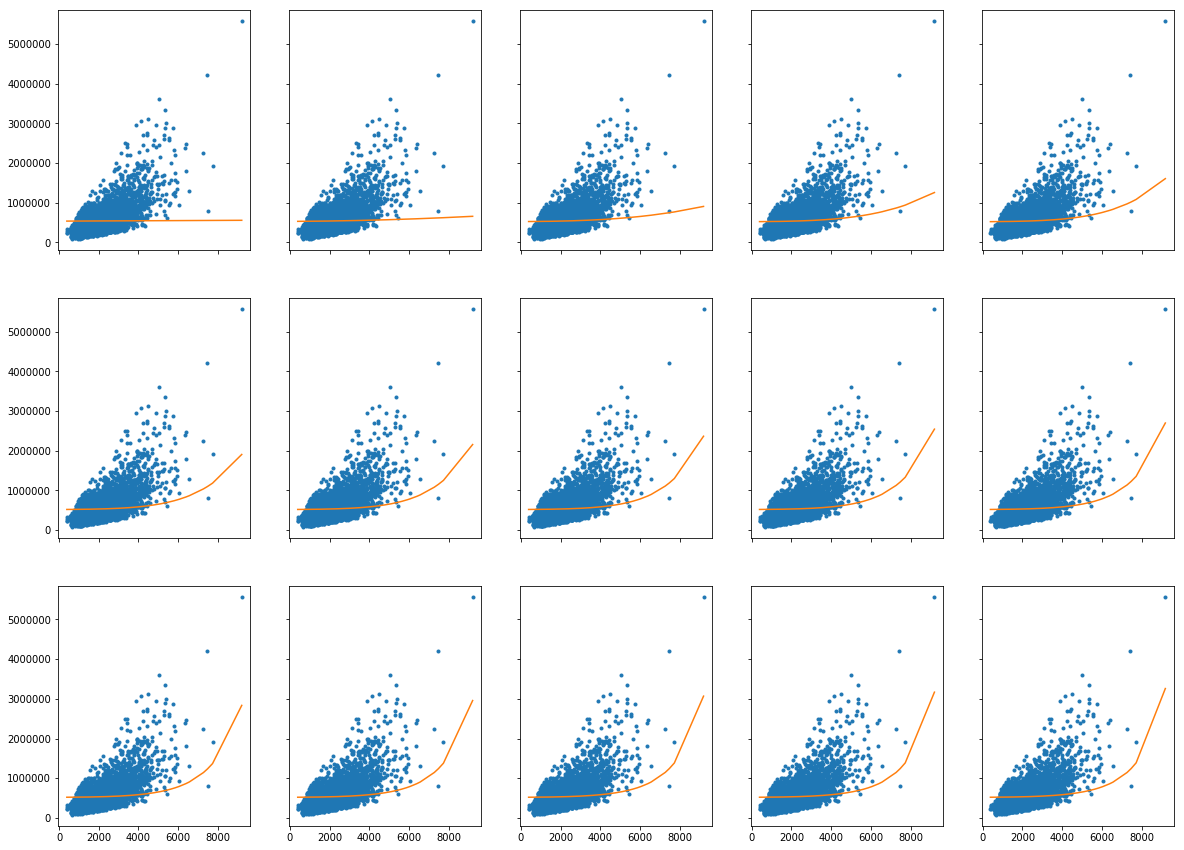

In [18]:
polynomial_regression_plot(15, set_2) # question 3

Learned polynomial for degree 15:
           15             14             13             12
1.917e-55 x  + 1.912e-51 x  + 1.911e-47 x  + 1.915e-43 x 
              11             10             9             8
 + 1.927e-39 x  + 1.954e-35 x  + 2.004e-31 x + 2.093e-27 x
              7             6             5             4             3
 + 2.247e-23 x + 2.501e-19 x + 2.876e-15 x + 3.209e-11 x + 2.776e-07 x
             2
 + 0.001259 x + 2.269 x + 5.229e+05


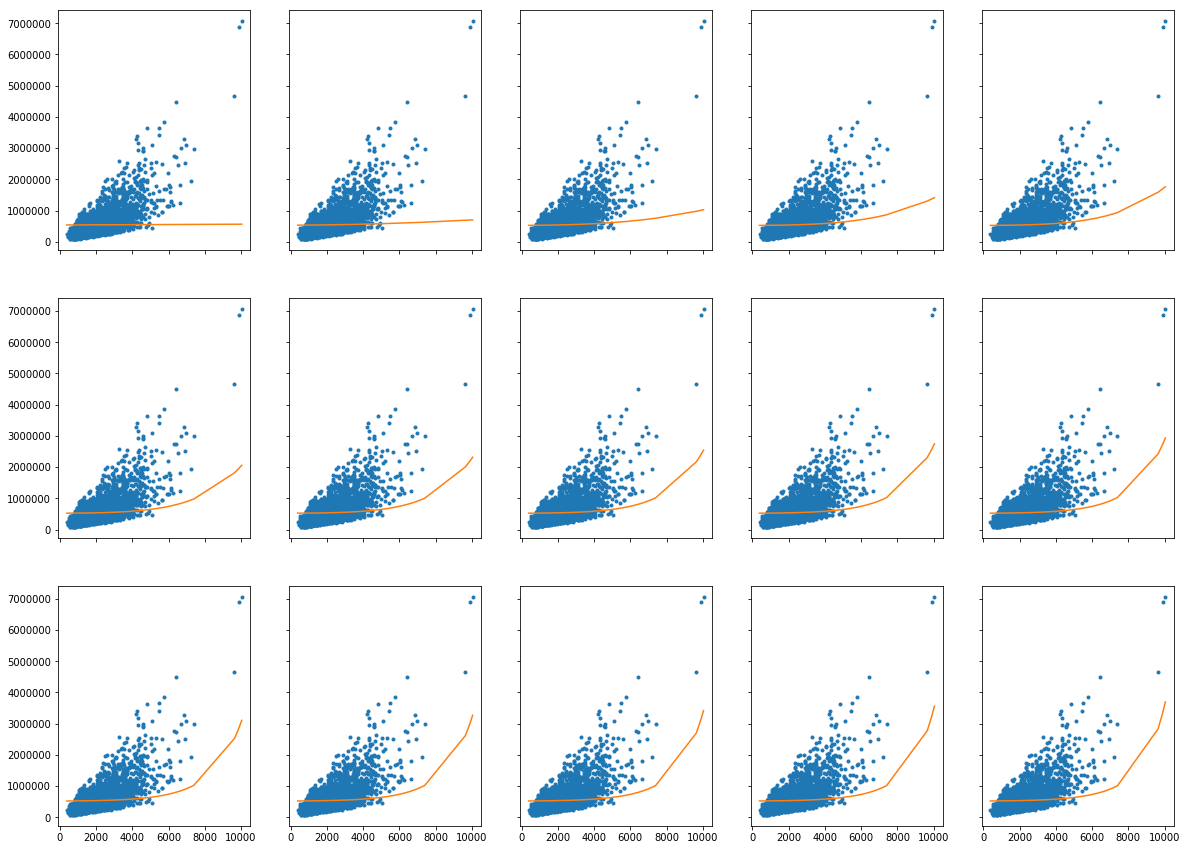

In [19]:
polynomial_regression_plot(15, set_3) # question 3

Learned polynomial for degree 15:
           15             14            13             12
2.679e-54 x  + 2.275e-50 x  + 1.94e-46 x  + 1.663e-42 x 
              11             10             9             8
 + 1.436e-38 x  + 1.253e-34 x  + 1.108e-30 x + 9.957e-27 x
              7            6             5             4             3
 + 9.065e-23 x + 8.25e-19 x + 7.205e-15 x + 5.501e-11 x + 3.128e-07 x
             2
 + 0.001101 x + 1.91 x + 5.137e+05


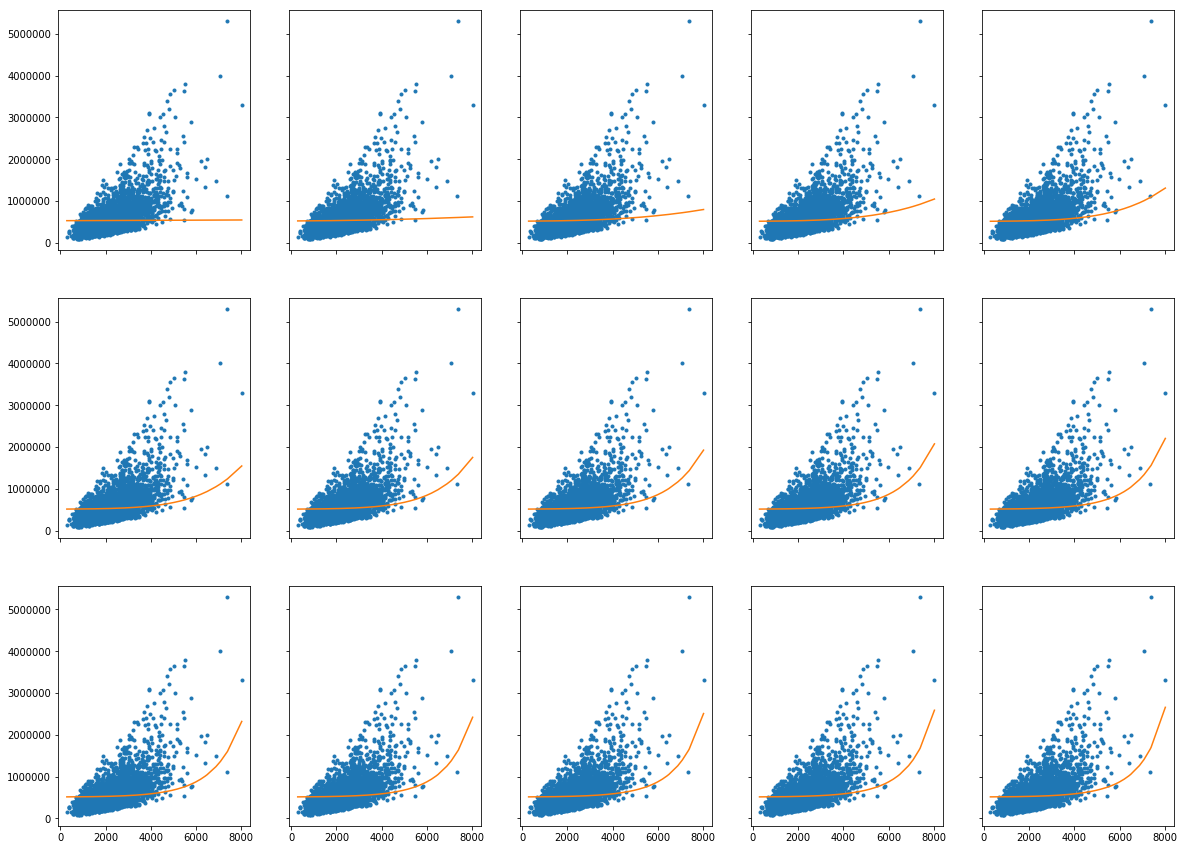

In [20]:
polynomial_regression_plot(15, set_4) # question 3

In [21]:
(train_valid, test) = sales.random_split(.9, seed=1)
train_valid_shuffled = shuffle_sframe(train_valid, random_seed=1)

In [22]:
n = len(train_valid_shuffled)
k = 10 # 10-fold cross-validation

for i in range(k):
    start = (n*i)/k
    end = (n*(i+1))/k-1
    print(i, (start, end))

0 (0.0, 1938.6)
1 (1939.6, 3878.2)
2 (3879.2, 5817.8)
3 (5818.8, 7757.4)
4 (7758.4, 9697.0)
5 (9698.0, 11636.6)
6 (11637.6, 13576.2)
7 (13577.2, 15515.8)
8 (15516.8, 17455.4)
9 (17456.4, 19395.0)


In [50]:
# train_valid_shuffled[0:10] # select rows 0 to 9

In [51]:
print(n)

19396


In [52]:
validations = [train_valid_shuffled[(n*i)/k : (n*(i+1))/k] for i in range(k)]

In [53]:
print(int(round(validations[3]['price'].mean(), 0)))


559490


In [54]:
n = len(train_valid_shuffled)
first_two = train_valid_shuffled[0:2]
last_two = train_valid_shuffled[n-2:n]
print(first_two.append(last_two))

+------------+---------------------------+-----------+----------+-----------+
|     id     |            date           |   price   | bedrooms | bathrooms |
+------------+---------------------------+-----------+----------+-----------+
| 8001600150 | 2015-03-10 00:00:00+00:00 |  300000.0 |   3.0    |    1.5    |
| 7237501370 | 2014-07-17 00:00:00+00:00 | 1079000.0 |   4.0    |    3.25   |
| 4077800582 | 2014-09-12 00:00:00+00:00 |  522000.0 |   3.0    |    1.0    |
| 7853370620 | 2015-02-06 00:00:00+00:00 |  605000.0 |   5.0    |    4.0    |
+------------+---------------------------+-----------+----------+-----------+
+-------------+----------+--------+------------+------+-----------+-------+------------+
| sqft_living | sqft_lot | floors | waterfront | view | condition | grade | sqft_above |
+-------------+----------+--------+------------+------+-----------+-------+------------+
|    1810.0   |   8232   |   1    |     0      |  0   |     3     |   8   |    1810    |
|    4800.0   |  127

In [56]:
first_part = train_valid_shuffled[:(n*3)/k]
last_part = train_valid_shuffled[(n*(3+1))/k:]
train4 = first_part.append(last_part)
print(len(train4))

17456


In [60]:
print(int(round(train4['price'].mean(), 0)))

536866


In [61]:
def k_fold_cross_validation(k, l2_penalty, data, output_name, features_list):    
    rss_sum = 0
    n = len(data)
    for i in range(k):
        start = (n*i)/k
        end = (n*(i+1))/k-1
        validation_set = data[start:end+1]
        training_set = data[0:start].append(data[end+1:n])    
        model = tc.linear_regression.create(training_set, 
                                            target = output_name, 
                                            features = features_list, 
                                            l2_penalty=l2_penalty, 
                                            validation_set=None, 
                                            verbose=False)
        predictions = model.predict(validation_set)
        residuals = validation_set['price'] - predictions
        rss = sum(residuals * residuals)
        rss_sum += rss
    validation_error = rss_sum / k 
    return validation_error

Once we have a function to compute the average validation error for a model, we can write a loop to find the model that minimizes the average validation error. Write a loop that does the following:
We will again be aiming to fit a 15th-order polynomial model using the sqft_living input
For l2_penalty in [10^1, 10^1.5, 10^2, 10^2.5, ..., 10^7] (to get this in Python, you can use this Numpy function: np.logspace(1, 7, num=13).)
Run 10-fold cross-validation with l2_penalty
Report which L2 penalty produced the lowest average validation error.
Note: since the degree of the polynomial is now fixed to 15, to make things faster, you should generate polynomial features in advance and re-use them throughout the loop. Make sure to use train_valid_shuffled when generating polynomial features!

In [64]:
poly_data = polynomial_sframe(train_valid_shuffled['sqft_living'], 15)
my_features = poly_data.column_names()
poly_data['price'] = train_valid_shuffled['price']

val_err_dict = {}
for l2_penalty in np.logspace(1, 7, num=13):
    val_err = k_fold_cross_validation(10, l2_penalty, poly_data, 'price', my_features)    
    print('Penalty: ' + str(l2_penalty))
    val_err_dict[l2_penalty] = val_err
print(val_err_dict)

Penalty: 10.0
Penalty: 31.6227766017
Penalty: 100.0
Penalty: 316.227766017
Penalty: 1000.0
Penalty: 3162.27766017
Penalty: 10000.0
Penalty: 31622.7766017
Penalty: 100000.0
Penalty: 316227.766017
Penalty: 1000000.0
Penalty: 3162277.66017
Penalty: 10000000.0
{10.0: 624702191121622.6, 31.622776601683793: 359522655653556.3, 100.0: 182500743259116.0, 316.22776601683796: 124345198802783.05, 1000.0: 120963607540272.55, 3162.2776601683795: 123921949369658.3, 10000.0: 137124115043470.4, 31622.776601683792: 171719392909609.53, 100000.0: 229172267792690.34, 316227.76601683791: 252982618532326.3, 1000000.0: 258749755747611.9, 3162277.6601683795: 262867019171978.56, 10000000.0: 264926581622710.7}


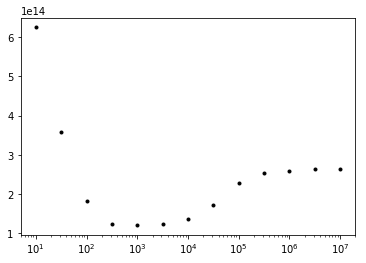

In [74]:
plt.plot(val_err_dict.keys(),val_err_dict.values(),'k.')
plt.xscale('log')

In [70]:
best_value = min(val_err_dict.items(), key=lambda x: x[1])
print(best_value[0])

1000.0


In [71]:
poly_data = polynomial_sframe(train_valid_shuffled['sqft_living'], 15)
features_list = poly_data.column_names()
poly_data['price'] = train_valid_shuffled['price']
l2_penalty_best = best_value[0]

model = tc.linear_regression.create(poly_data, target='price',
                                         features=features_list,
                                         l2_penalty=l2_penalty_best,
                                         validation_set=None)

Linear regression:

--------------------------------------------------------

Number of examples          : 19396

Number of features          : 15

Number of unpacked features : 15

Number of coefficients    : 16

Starting Newton Method

--------------------------------------------------------

+-----------+----------+--------------+--------------------+---------------------------------+

| Iteration | Passes   | Elapsed Time | Training Max Error | Training Root-Mean-Square Error |

+-----------+----------+--------------+--------------------+---------------------------------+

| 0         | 1        | 0.009600     | 7700000.000000     | 654066.887811                   |

| 1         | 2        | 0.034840     | 2461778.986191     | 248914.007014                   |

+-----------+----------+--------------+--------------------+---------------------------------+

SUCCESS: Optimal solution found.

In [72]:
poly_test = polynomial_sframe(test['sqft_living'], 15)
predictions = model.predict(poly_test)
errors = predictions-test['price']
rss = (errors*errors).sum()
print(rss)

128780855058449.31
